In [1]:
import os 
os.chdir ('/projects/bbhj/asinha15/VLQ-NN-Reweighting/main')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from Data import CSVData

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
model_path = '/projects/bbhj/asinha15/VLQ-NN-Reweighting/main/trained_models/model_scripted7.pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
)

In [4]:
features = ['mode',
'Msim',
'Gsim',
'weight',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/projects/bbhj/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])
test_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/projects/bbhj/asinha15/test_' + str(i)+'.csv' for i in range(0,10)])

X, Y = train_data.load_data_many()
train_inputs = torch.Tensor(np.array(X)).to(device)
train_labels = torch.Tensor(np.log(np.array(Y))).to(device)
del X, Y

X, Y = test_data.load_data_many()
test_inputs = torch.Tensor(np.array(X)).to(device)
test_labels = torch.Tensor(np.log(np.array(Y))).to(device)
del X, Y

In [5]:
with torch.no_grad():
    train_out=torch.reshape(model(train_inputs), [9000000]).to('cpu')
    test_out=torch.reshape(model(test_inputs), [1500000]).to('cpu')

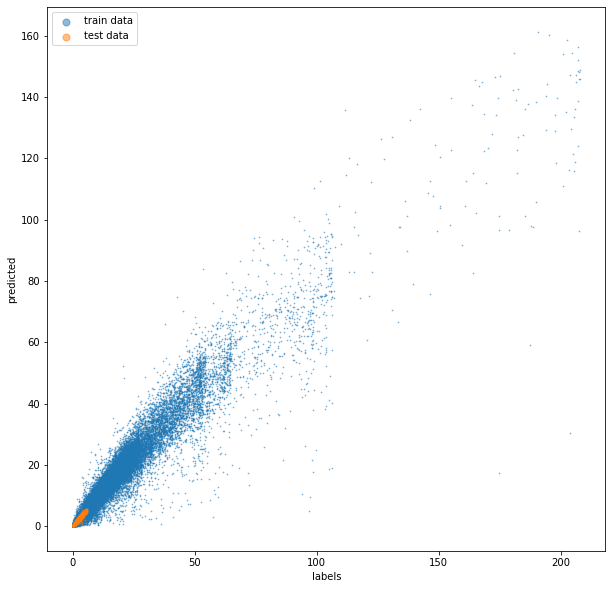

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(np.exp(train_labels.to('cpu')), np.exp(train_out), s=0.5, alpha=0.5, label='train data')
plt.scatter(np.exp(test_labels.to('cpu')), np.exp(test_out), s=0.5, alpha=0.5, label='test data')
plt.xlabel('labels')
plt.ylabel('predicted')
plt.legend(markerscale=10)
plt.show()

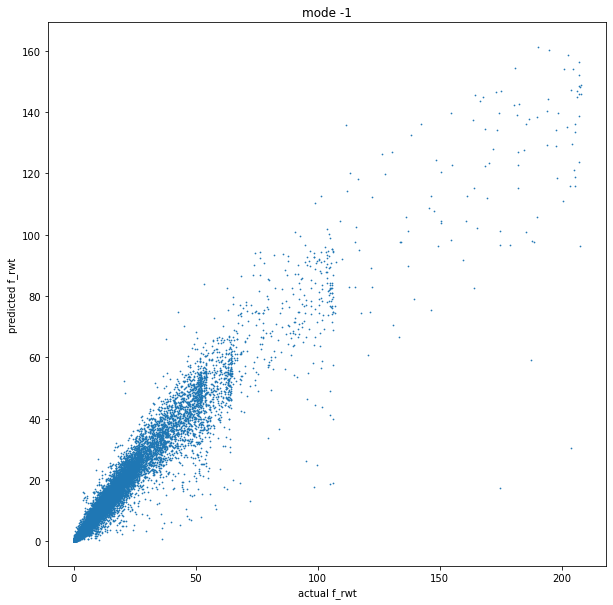

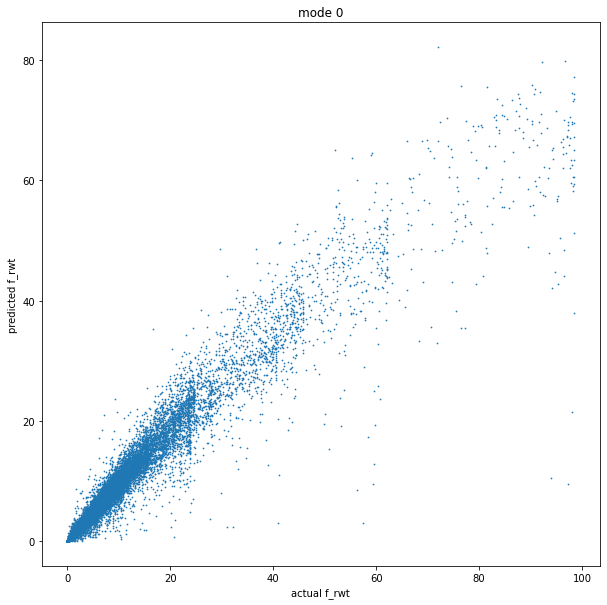

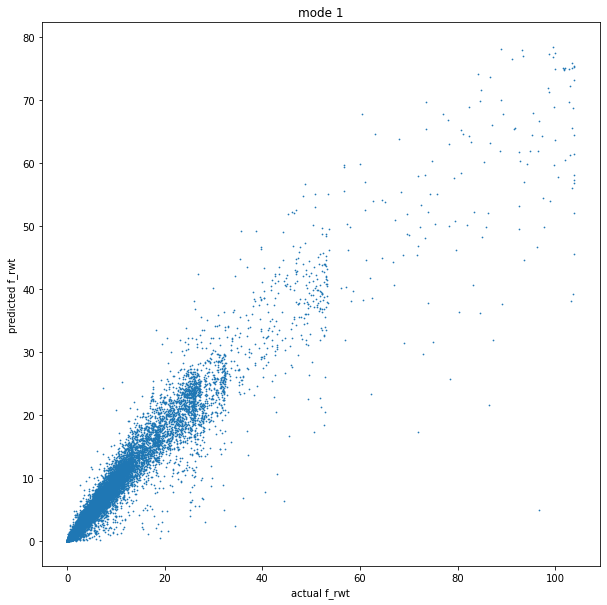

In [24]:
df_all = pd.DataFrame(train_inputs.to('cpu'))
df_all.columns = features
modes = [-1,0,1]
train_labels=train_labels.to('cpu')
for i, b in enumerate(modes):
    idx = df_all.index[df_all['mode']==b].tolist()
    scat_mode = pd.DataFrame(np.array([[np.exp(train_labels[idxi].item()) for idxi in idx], [np.exp(train_out[idxi].item()) for idxi in idx]])).transpose()
    scat_mode.columns = ['actual', 'pred']
    scat_mode.plot.scatter(x='actual', y='pred', legend=False, xlabel='actual f_rwt', ylabel='predicted f_rwt', title='mode '+str(b), figsize=(10, 10), s=0.5)
    del scat_mode
del df_all

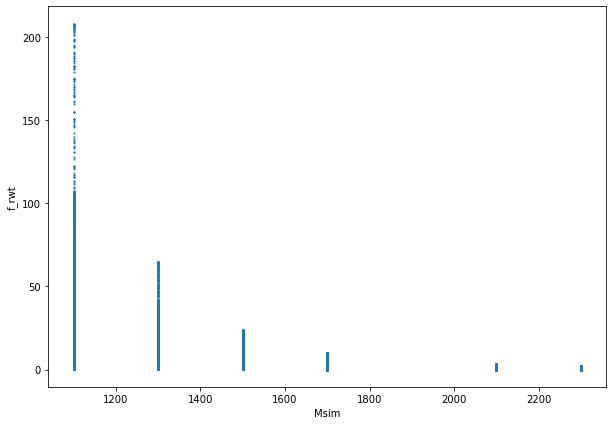

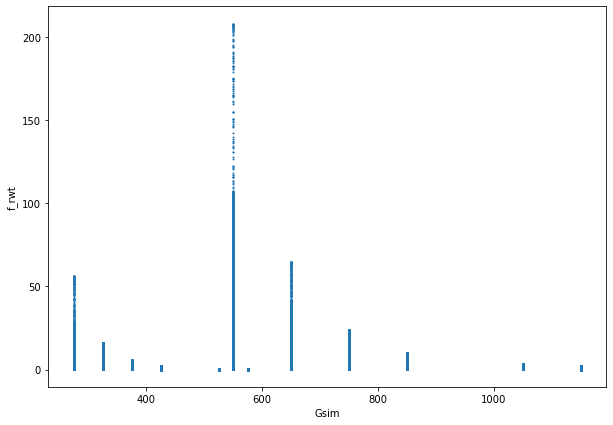

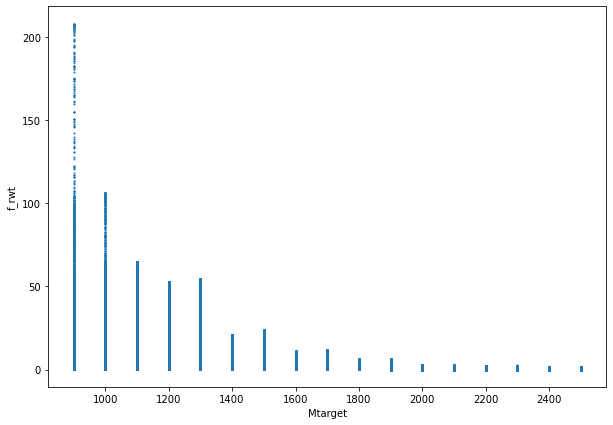

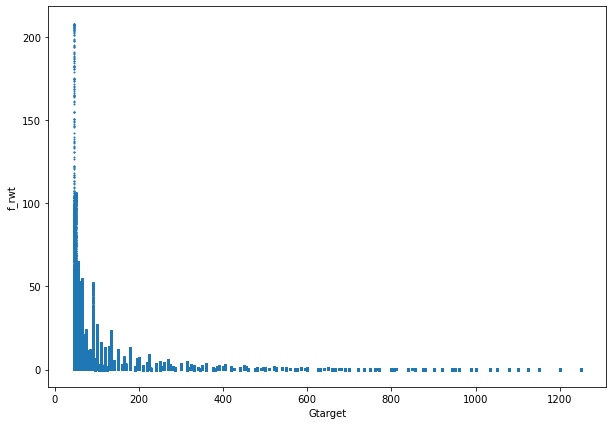

In [30]:
df_all = pd.DataFrame(train_inputs.to('cpu'))
df_all.columns = features
feats = ['Msim', 'Gsim', 'Mtarget', 'Gtarget']
for feat in feats:
    plt.figure(figsize=(10,7))
    plt.scatter(df_all[feat], np.exp(train_labels.to('cpu')), s=1, label='train data')
    plt.xlabel(feat)
    plt.ylabel('f_rwt')
    plt.show()
del df_all

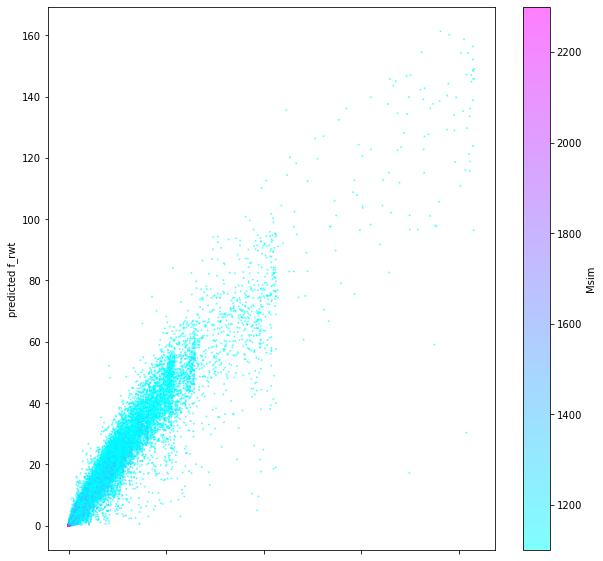

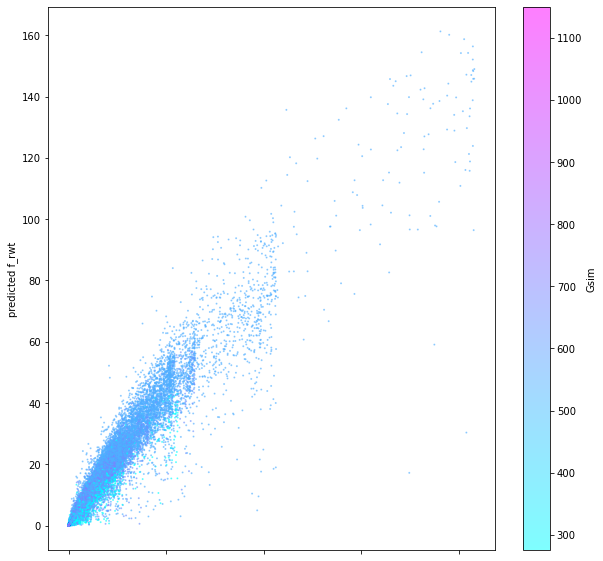

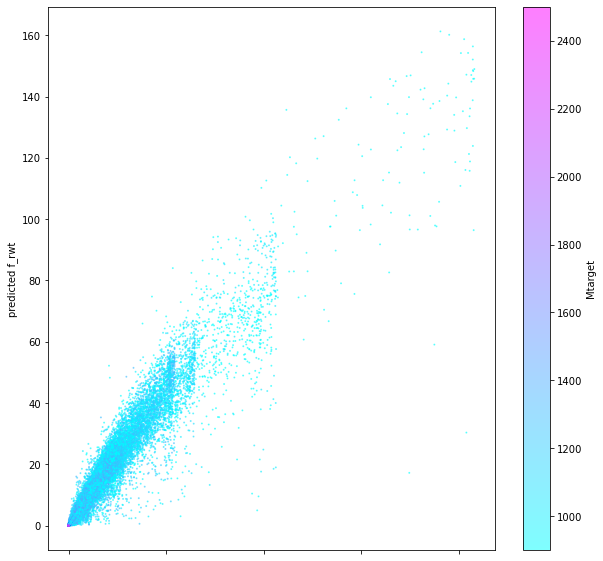

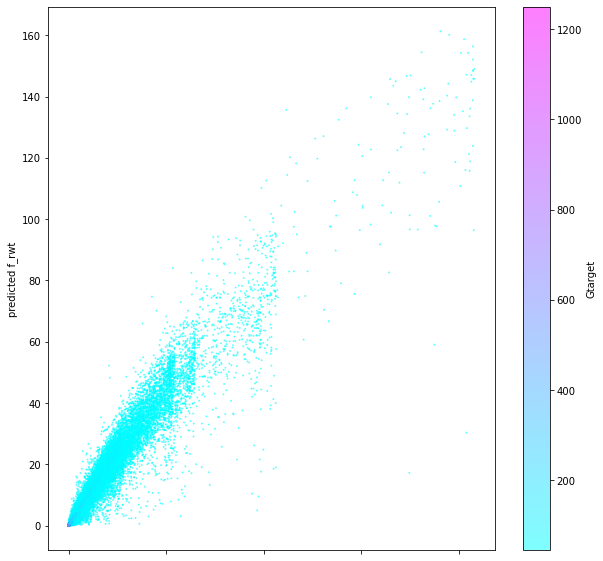

In [31]:
df_all = pd.DataFrame(train_inputs.to('cpu'))
df_all.columns = features
feats = ['Msim', 'Gsim', 'Mtarget', 'Gtarget']
for feat in feats:
    feat_df = pd.DataFrame(np.array([df_all[feat], np.exp(train_labels.numpy()), np.exp(train_out.numpy())])).transpose()
    feat_df.columns = [feat, 'actual f_rwt', 'predicted f_rwt']
    feat_df.plot.scatter('actual f_rwt', 'predicted f_rwt', c=feat, colormap='cool', s=1, alpha=0.5, xlabel='actual f_rwt', ylabel='predicted f_rwt', figsize=(10, 10))
    del feat_df
del df_all